In [39]:
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from transformers import BertTokenizer, BertForSequenceClassification, get_scheduler
from torch.optim import AdamW
import matplotlib.pyplot as plt
import os
from tqdm import tqdm

# 1. 加载数据
df = pd.read_csv("Financial_Fraud_Dataset.csv")  
df['Fraud'] = df['Fraud'].map({'yes': 1, 'no': 0})  # 转成0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              /1

train_texts, val_texts, train_labels, val_labels = train_test_split(
    df['Fillings'].tolist(), 
    df['Fraud'].tolist(), 
    test_size=0.2, 
    random_state=42
)

In [40]:
# 2. Tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=128)
val_encodings = tokenizer(val_texts, truncation=True, padding=True, max_length=128)

In [41]:
# 3. 自定义Dataset
class FraudDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels
    
    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item
    
    def __len__(self):
        return len(self.labels)

train_dataset = FraudDataset(train_encodings, train_labels)
val_dataset = FraudDataset(val_encodings, val_labels)

In [45]:
# 4. 加载模型
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2,hidden_dropout_prob=0.2)

# 5. 优化器
optimizer = AdamW(model.parameters(), lr=2e-5)

# 6. 学习率调度器
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16)

num_training_steps = len(train_loader) * 5  # 5 epochs
lr_scheduler = get_scheduler(
    name="linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=num_training_steps
)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [43]:
# 7. 训练
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)
best_f1 = 0
early_stop_counter = 0
patience = 3
train_losses = []
val_accuracies = []

for epoch in range(5):
    model.train()
    loop = tqdm(train_loader, leave=True)
    epoch_loss = 0
    for batch in loop:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        loss = outputs.loss
        loss.backward()
        
        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()

        epoch_loss += loss.item()
        loop.set_description(f'Epoch {epoch}')
        loop.set_postfix(loss=loss.item())
        
    epoch_loss /= len(train_loader)
    train_losses.append(epoch_loss)
    

# 验证
    model.eval()
    preds = []
    labels = []
    with torch.no_grad():
        for batch in val_loader:
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(**batch)
            logits = outputs.logits
            preds += torch.argmax(logits, dim=1).tolist()
            labels += batch['labels'].tolist()
    
    acc = accuracy_score(labels, preds)
    precision = precision_score(labels, preds)
    recall = recall_score(labels, preds)
    f1 = f1_score(labels, preds)
    val_accuracies.append(acc)

    print(f"Validation Accuracy: {acc:.4f} | Precision: {precision:.4f} | Recall: {recall:.4f} | F1: {f1:.4f}")

    # Early stopping
    if f1 > best_f1:
        best_f1 = f1
        early_stop_counter = 0
        if not os.path.exists('best_model'):
            os.makedirs('best_model')
        model.save_pretrained('best_model')
        tokenizer.save_pretrained('best_model')
        print("Best model saved!")
    else:
        early_stop_counter += 1
        if early_stop_counter >= patience:
            print("Early stopping triggered.")
            break

Epoch 0: 100%|███████████████████████████████████████████████████████████████| 9/9 [01:14<00:00,  8.28s/it, loss=0.614]


Validation Accuracy: 0.7353 | Precision: 0.6667 | Recall: 0.8750 | F1: 0.7568
Best model saved!


Epoch 1: 100%|███████████████████████████████████████████████████████████████| 9/9 [01:22<00:00,  9.18s/it, loss=0.509]


Validation Accuracy: 0.7647 | Precision: 0.7000 | Recall: 0.8750 | F1: 0.7778
Best model saved!


Epoch 2: 100%|███████████████████████████████████████████████████████████████| 9/9 [01:20<00:00,  8.92s/it, loss=0.564]


Validation Accuracy: 0.7647 | Precision: 0.7000 | Recall: 0.8750 | F1: 0.7778


Epoch 3: 100%|███████████████████████████████████████████████████████████████| 9/9 [01:18<00:00,  8.71s/it, loss=0.635]


Validation Accuracy: 0.7647 | Precision: 0.7000 | Recall: 0.8750 | F1: 0.7778


Epoch 4: 100%|███████████████████████████████████████████████████████████████| 9/9 [01:19<00:00,  8.84s/it, loss=0.279]


Validation Accuracy: 0.7647 | Precision: 0.7222 | Recall: 0.8125 | F1: 0.7647
Early stopping triggered.


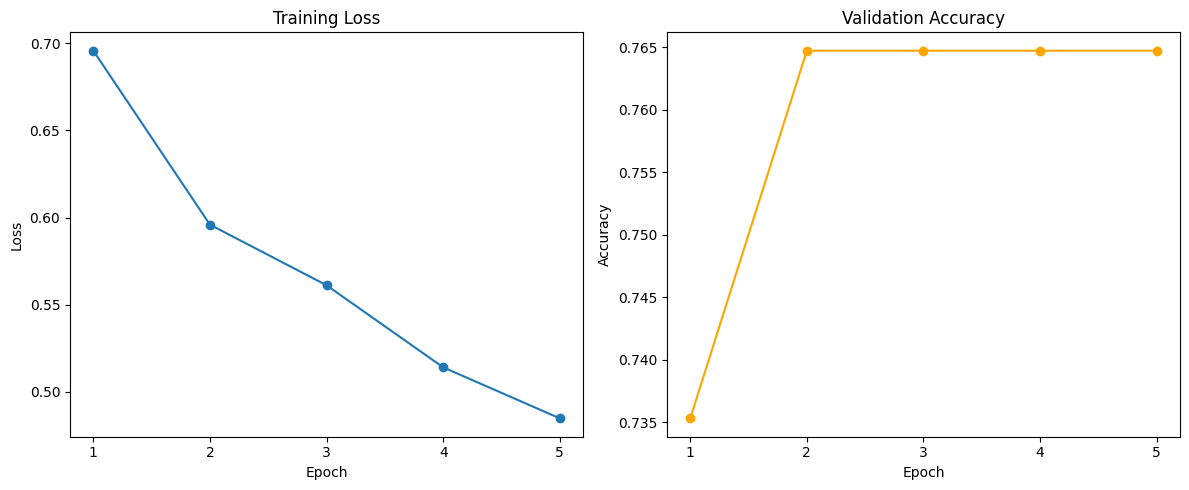

In [44]:
# 7. 画出训练损失曲线 和 验证准确率曲线
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.xticks(range(1, 6))
plt.plot(range(1, len(train_losses)+1), train_losses, marker='o')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.subplot(1,2,2)
plt.xticks(range(1, 6))
plt.plot(range(1, len(val_accuracies)+1), val_accuracies, marker='o', color='orange')
plt.title('Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.tight_layout()
plt.savefig('training_curves.png')
plt.show()